## Notebook for Fig. 4 of the paper

This notebook is similar to the notebook "plot_fig1.ipynb", but for the compound uncertainty estimate discussed in the paper

In [1]:
import numpy as np
from scipy.optimize import least_squares
from PMM import PMM
from tqdm import tqdm
from joblib import Parallel, delayed
import pickle 

In [2]:
file = open('ML_files/MLP_scaler_s1.pickle', 'rb')
scaler_X = pickle.load(file)   
file.close()

file = open('ML_files/MLP_scaler_y_s1.pickle', 'rb')
scaler_y = pickle.load(file)   
file.close()

file = open('ML_files/MLP_s1.pickle', 'rb')
MLP_regr = pickle.load(file)
#MLP_regr.n_jobs = 1
file.close()

In [3]:
n_train = 30
n_val = 100 - n_train

x_test = []

y_true_14 = []

for i in (range(n_val)):

    NS_val = np.loadtxt('compound_unc_samples/NS_'+str(i+1)+'.dat')
    
    M_val = NS_val[:,1]
    L_val = NS_val[:,2]
    
    x_test.append( np.loadtxt('compound_unc_samples/params_'+str(i+1)+'.dat')  )

    y_true_14.append( np.interp(1.4,M_val, np.log10(L_val)) )
        

y_pred = np.array( scaler_y.inverse_transform(  MLP_regr.predict(scaler_X.transform(x_test))) ) 

y_true_14 = 10**np.array(y_true_14)

In [4]:
M_grid = np.linspace(1,2,num=30)

PU_NN = []

for i in range(len(y_true_14)):
    temp = 10**np.interp(1.4,M_grid, (y_pred[i]))
    
    PU_NN.append(  np.abs((temp-y_true_14[i])/y_true_14[i]*100)  )

100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 5642.92it/s]


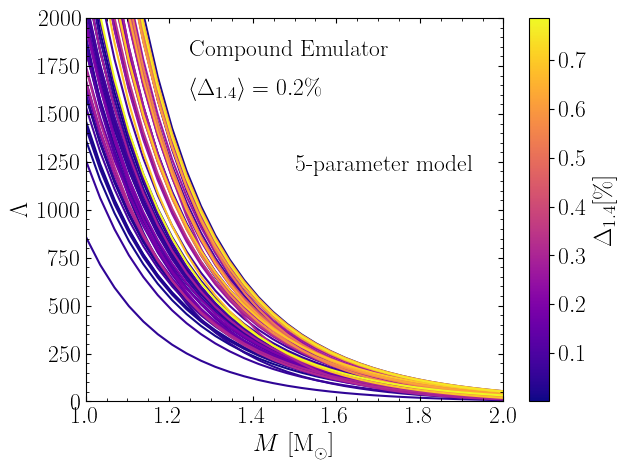

In [5]:
import matplotlib.pyplot as plt

from matplotlib import cm, colors
import matplotlib
plt.rcParams['text.usetex'] = True

fontsize = 18
fig, ax = plt.subplots()

cmap = plt.get_cmap("plasma")

norm = colors.Normalize(np.amin(PU_NN), np.amax(PU_NN))   


for i in tqdm(range(len(y_true_14))[:]):   
    ax.plot( M_grid, 10**y_pred[i],color=cmap(norm(PU_NN[i])) ,zorder=PU_NN[i] )  
    
s = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)  
s.ax.set_ylabel(r'$\Delta_{1.4} [\%]$',fontsize=fontsize)
s.ax.tick_params(labelsize=fontsize-1) 

ax.set_xlabel(r'$M \ \textrm{[M}_\odot$\textrm{]}',fontsize=fontsize)
ax.set_ylabel(r'$\Lambda$',fontsize=fontsize)


ax.set_ylim(top=2000,bottom=0)
ax.set_xlim(left = 1, right = 2)

ax.minorticks_on()

ax.tick_params(axis='both',which='both',direction='in',bottom=True,top=True,left=True,right=True,labelsize=fontsize-1)

ax.text(0.25,0.9,r'\textrm{Compound Emulator}',fontsize=fontsize-1,transform = ax.transAxes)
ax.text(0.25,0.8,r'$\langle \Delta_{1.4} \rangle = 0.2 \%$',fontsize=fontsize-1,transform = ax.transAxes)
ax.text(0.5,0.6,r'$\textrm{5-parameter model}$',fontsize=fontsize-1,transform = ax.transAxes)

plt.tight_layout()

plt.savefig('figures/compound_unc.pdf',bbox_inches='tight')


In [6]:
with open('source_data/fig4.txt', 'w') as f:
    for i, line in enumerate(ax.get_lines(), start=1):
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        
        f.write(f'Line {i}:\n')
        f.write('X\tY\n')
        for x, y in zip(x_data, y_data):
            f.write(f'{x}\t{y}\n')
        f.write('\n')  